   Running Deep Learning (LSTM) Model
   Scaler Type: Standard Scaler (Z-Score)
   Scaled File: Suvarnabhumi_Scaled_Cyclical_Standard_FS_Arrival
   Unscaled File: Suvarnabhumi_NotScaled_Cyclical_Standard_FS_Arrival
Loading and preprocessing data...
Statistics for Inverse Transform:
Mean: 10531.3028, Std: 2853.7333
Data Split: Train=734, Test=184

Starting Grid Search for LSTM...
----------------------------------------------------------

[Progress 1/54] Testing Params: {'units': 32, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.01}
  > Fold 1/5: Training... Done. (RMSE: 1285.88)
  > Fold 2/5: Training... Done. (RMSE: 913.67)
  > Fold 3/5: Training... Done. (RMSE: 570.55)
  > Fold 4/5: Training... Done. (RMSE: 2037.26)
  > Fold 5/5: Training... Done. (RMSE: 480.43)
  >>> Average RMSE for this set: 1057.5560

[Progress 2/54] Testing Params: {'units': 32, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.001}
  > Fold 1/5: Training... Done. (RMSE: 1239.14)
  > Fold 2/5: Training... 

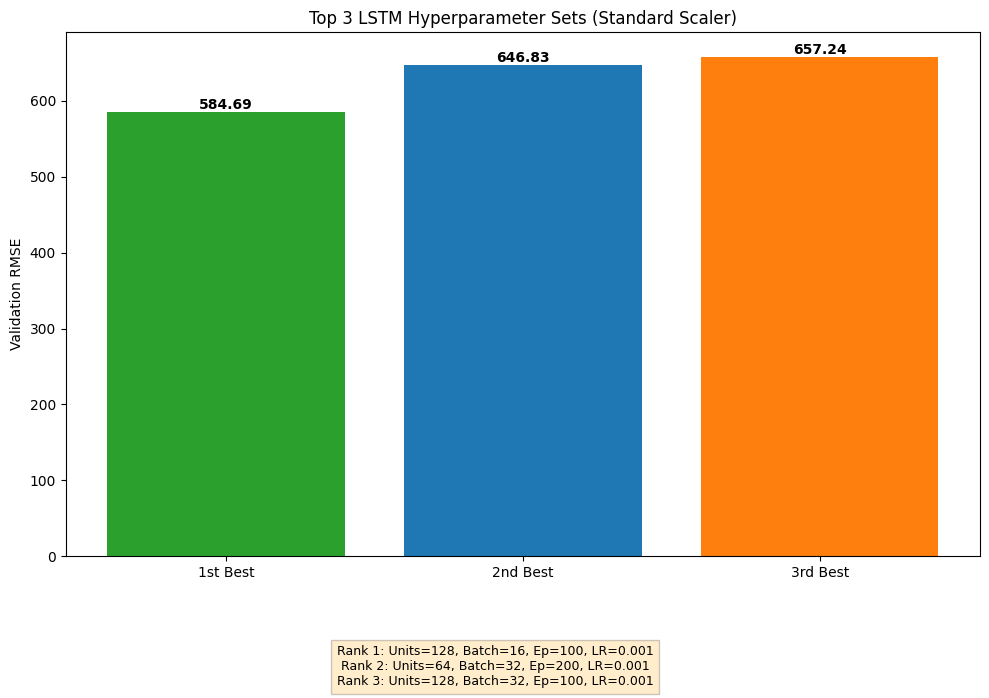


--- Top 3 Best Parameters ---
Rank 1: Units=128, Batch=16, Ep=100, LR=0.001
Rank 2: Units=64, Batch=32, Ep=200, LR=0.001
Rank 3: Units=128, Batch=32, Ep=100, LR=0.001

Retraining FINAL MODEL with Best Params
Params: {'units': 128, 'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001}
Epoch 1/100
46/46 [==============================] - 1s 2ms/step - loss: 0.6777
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss

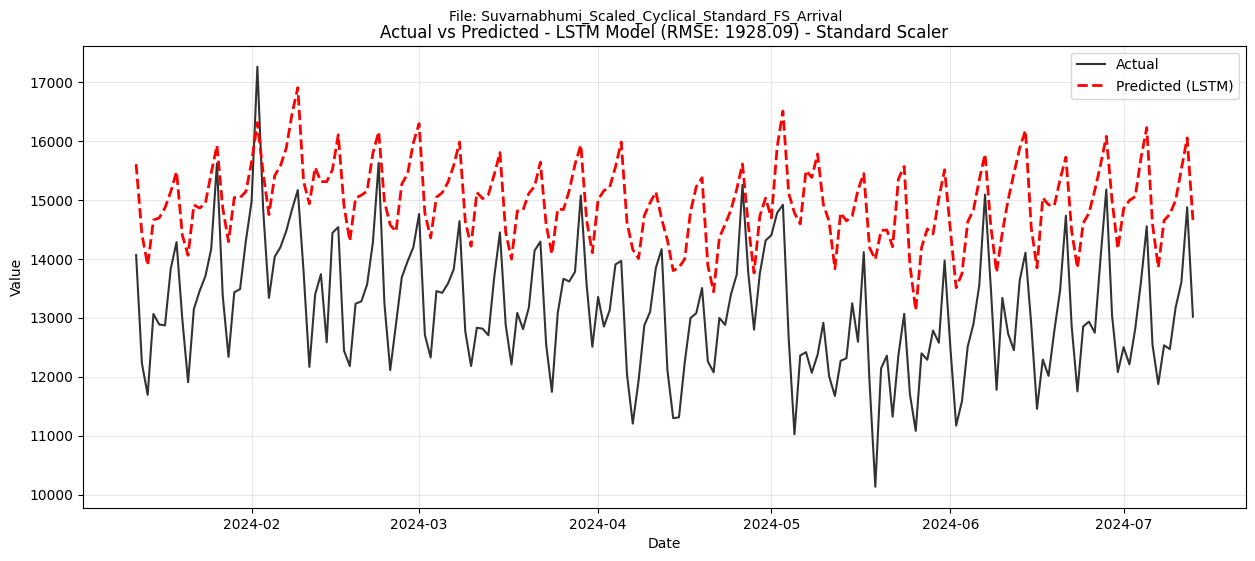

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os
import random
import sys

# ตั้งค่า Seed เพื่อผลลัพธ์ที่เหมือนเดิม (Reproducibility)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def create_LSTM_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    """ฟังก์ชันสร้างโมเดล LSTM"""
    model = Sequential()
    # LSTM Layer
    model.add(LSTM(units, input_shape=input_shape, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    # Output Layer (1 node สำหรับ Regression)
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def run_deep_learning_LSTM(scaled_file, unscaled_file):
    set_seed(42)

    print(f"==========================================")
    print(f"   Running Deep Learning (LSTM) Model")
    print(f"   Scaler Type: Standard Scaler (Z-Score)")
    print(f"   Scaled File: {scaled_file[5:-4]}")
    print(f"   Unscaled File: {unscaled_file[5:-4]}")
    print(f"==========================================")

    # ---------------------------------------------------------
    # 1. Load Data & Preprocessing
    # ---------------------------------------------------------
    print("Loading and preprocessing data...")
    df_scaled = pd.read_csv(scaled_file)
    df_unscaled = pd.read_csv(unscaled_file)

    # แปลง Date และ Sort
    df_scaled['Date'] = pd.to_datetime(df_scaled['Date'])
    df_unscaled['Date'] = pd.to_datetime(df_unscaled['Date'])
    df_scaled = df_scaled.sort_values('Date').reset_index(drop=True)
    df_unscaled = df_unscaled.sort_values('Date').reset_index(drop=True)

    # Align Data (เอาเฉพาะวันที่ที่มีในทั้งสองไฟล์)
    common_dates = df_scaled['Date'][df_scaled['Date'].isin(df_unscaled['Date'])]
    df_scaled = df_scaled[df_scaled['Date'].isin(common_dates)].reset_index(drop=True)
    df_unscaled = df_unscaled[df_unscaled['Date'].isin(common_dates)].reset_index(drop=True)

    # ระบุ Target (คอลัมน์ที่ 2 เสมอ)
    target_col_scaled = df_scaled.columns[1]
    target_col_unscaled = df_unscaled.columns[1]

    # เตรียม X, y (Scaled)
    X = df_scaled.drop(columns=['Date', target_col_scaled]).values
    y = df_scaled[target_col_scaled].values

    # เตรียมค่า Mean/Std สำหรับ Inverse Transform
    y_mean = df_unscaled[target_col_unscaled].mean()
    y_std = df_unscaled[target_col_unscaled].std()
    
    print(f"Statistics for Inverse Transform:")
    print(f"Mean: {y_mean:.4f}, Std: {y_std:.4f}")

    # เตรียม y_real_full (ค่าจริง unscaled)
    y_real_full = df_unscaled[target_col_unscaled].values

    # Reshape X สำหรับ LSTM: [Samples, TimeSteps, Features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # ---------------------------------------------------------
    # 2. Train-Test Split (80:20 Time Series)
    # ---------------------------------------------------------
    train_size = int(len(X) * 0.8)
    X_train_full, X_test = X[:train_size], X[train_size:]
    y_train_full, y_test = y[:train_size], y[train_size:]

    # เก็บค่าจริงของ Test Set ไว้เทียบผล
    y_test_real = y_real_full[train_size:]
    test_dates = df_unscaled['Date'].iloc[train_size:]

    print(f"Data Split: Train={X_train_full.shape[0]}, Test={X_test.shape[0]}")

    # ---------------------------------------------------------
    # 3. Grid Search
    # ---------------------------------------------------------
    print("\nStarting Grid Search for LSTM...")
    print("----------------------------------------------------------")

    # กำหนด Parameter Grid
    param_grid = {
        'units': [32, 64, 128],
        'batch_size': [16, 32, 64],
        'epochs': [50, 100, 200],
        'learning_rate': [0.01, 0.001]
    }

    import itertools
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    total_combinations = len(param_combinations)

    tscv = TimeSeriesSplit(n_splits=5)
    results = []

    for i, params in enumerate(param_combinations):
        print(f"\n[Progress {i+1}/{total_combinations}] Testing Params: {params}")

        fold_rmses = []

        for fold_idx, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
            print(f"  > Fold {fold_idx+1}/5: Training...", end=' ')
            sys.stdout.flush()

            X_cv_train, X_cv_val = X_train_full[train_index], X_train_full[val_index]
            y_cv_train, y_cv_val = y_train_full[train_index], y_train_full[val_index]

            model = create_LSTM_model(
                input_shape=(X_cv_train.shape[1], X_cv_train.shape[2]),
                units=params['units'],
                learning_rate=params['learning_rate']
            )

            model.fit(X_cv_train, y_cv_train,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0,
                      shuffle=False)

            # Predict & Evaluate
            pred_scaled = model.predict(X_cv_val, verbose=0)

            # ---------------------------------------------------------
            # [แก้ไข] Inverse Transform แบบ Standard Scaler
            # สูตร: real = scaled * std + mean
            # ---------------------------------------------------------
            pred_real = pred_scaled * y_std + y_mean
            actual_real = y_cv_val * y_std + y_mean

            rmse = np.sqrt(mean_squared_error(actual_real, pred_real))
            fold_rmses.append(rmse)

            print(f"Done. (RMSE: {rmse:.2f})")

        avg_rmse = np.mean(fold_rmses)
        results.append({'params': params, 'rmse': avg_rmse})
        print(f"  >>> Average RMSE for this set: {avg_rmse:.4f}")

    # ---------------------------------------------------------
    # 4. Analyze Top 3 Parameters
    # ---------------------------------------------------------
    print("\nAnalyzing Top 3 Results...")
    results_df = pd.DataFrame(results).sort_values('rmse')
    top_3 = results_df.head(3)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(3), top_3['rmse'], color=['#2ca02c', '#1f77b4', '#ff7f0e'])
    plt.xticks(range(3), ['1st Best', '2nd Best', '3rd Best'])
    plt.ylabel('Validation RMSE')
    plt.title('Top 3 LSTM Hyperparameter Sets (Standard Scaler)')

    param_texts = []
    for idx, (i, row) in enumerate(top_3.iterrows()):
        height = row['rmse']
        plt.text(idx, height, f"{height:.2f}", ha='center', va='bottom', fontweight='bold')

        p = row['params']
        p_str = f"Rank {idx+1}: Units={p['units']}, Batch={p['batch_size']}, Ep={p['epochs']}, LR={p['learning_rate']}"
        param_texts.append(p_str)

    plt.figtext(0.5, -0.15, "\n".join(param_texts), ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.2})
    plt.tight_layout()
    plt.show()

    print("\n--- Top 3 Best Parameters ---")
    for txt in param_texts:
        print(txt)

    # ---------------------------------------------------------
    # 5. Final Training with Best Params
    # ---------------------------------------------------------
    best_params = top_3.iloc[0]['params']
    print(f"\n==========================================")
    print(f"Retraining FINAL MODEL with Best Params")
    print(f"Params: {best_params}")
    print(f"==========================================")

    final_model = create_LSTM_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        units=best_params['units'],
        learning_rate=best_params['learning_rate']
    )

    history = final_model.fit(X_train_full, y_train_full,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1,
                    shuffle=False)

    # ---------------------------------------------------------
    # 6. Final Prediction & Metrics
    # ---------------------------------------------------------
    print("\nEvaluating on Test Set...")
    y_pred_scaled = final_model.predict(X_test)

    # ---------------------------------------------------------
    # [แก้ไข] Inverse Transform แบบ Standard Scaler
    # ---------------------------------------------------------
    y_pred_real = y_pred_scaled * y_std + y_mean
    y_pred_real = y_pred_real.flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

    print(f"\n--- Final Test Set Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    # ---------------------------------------------------------
    # 7. Plot Actual vs Predicted
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test_real, label='Actual', color='black', alpha=0.8)
    plt.plot(test_dates, y_pred_real, label='Predicted (LSTM)', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted - LSTM Model (RMSE: {rmse:.2f}) - Standard Scaler')
    plt.suptitle(f'File: {scaled_file[5:-4]}', y=0.94, fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    results = pd.DataFrame({
        'Units': [best_params['units']],
        'Batch_Size': [best_params['batch_size']],
        'Epochs': [best_params['epochs']],
        'Learning_Rate': [best_params['learning_rate']],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape]
    })
    
    # Save results
    results.to_csv(f'LSTM_Results_{scaled_file[5:-4]}_Standard.csv', index=False)

# ========================================================
# ส่วนกำหนดค่าเริ่มต้น (Configuration)
# ========================================================
if __name__ == "__main__":
    
    # หมายเหตุ: ควรเปลี่ยนชื่อไฟล์ให้เป็นไฟล์ที่ Scale แบบ Standard Scaler แล้ว
    # ตัวอย่างชื่อไฟล์ (สมมติ)
    scaled_file_path = r'data\Suvarnabhumi_Scaled_Cyclical_Standard_FS_Arrival.csv'
    unscaled_file_path = r'data\Suvarnabhumi_NotScaled_Cyclical_Standard_FS_Arrival.csv'

    # รันโปรแกรม
    if os.path.exists(scaled_file_path) and os.path.exists(unscaled_file_path):
        run_deep_learning_LSTM(scaled_file_path, unscaled_file_path)
    else:
        print("ไม่พบไฟล์ข้อมูล กรุณาตรวจสอบ path ในส่วน if __name__ == '__main__':")